In [2]:
from cStringIO import StringIO
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format

In [3]:
caffe_root = '../caffe/'  # set to the path of caffe installed.

import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

# If your GPU supports CUDA and Caffe was built with CUDA support,
# uncomment the following to run Caffe operations on the GPU.
caffe.set_mode_gpu()
caffe.set_device(0) # select GPU device if multiple devices exist

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


In [4]:
model_path = caffe_root + 'models/bvlc_googlenet/' # substitute your path here
net_fn   = model_path + 'deploy.prototxt'
param_fn = model_path + 'bvlc_googlenet.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier('tmp.prototxt', param_fn,
                       mean = np.float32([104.0, 116.0, 122.0]), # ImageNet mean, training set dependent
                       channel_swap = (2,1,0)) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])


In `objective_L2`, we directly set the gradients (`diff`) of the blob of dst to its `data`.

In [5]:
def objective_L2(dst):
    # Set the gradients as the data.
    dst.diff[:] = dst.data
    print("objective_L2 data: " + str(dst.data.shape) + " diff: " + str(dst.diff.shape))

def make_step(net, step_size=1.5, end='inception_4c/output', 
              jitter=32, clip=True, objective=objective_L2):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
    
    # Run a forward pass until `end` layer.
    net.forward(end=end)
    objective(dst)  # specify the optimization objective
    # Run a backward pass.
    net.backward(start=end)
    # Get the gradients on the input image
    # It reflects how much the change it needs to close up the expected output.
    # Here the output is not the label in the trainning/testing step,
    # it is the data of the "end" layer.
    # So the deepdream does is, what the trained net thinks about the input image,
    # we are going to enhance it.
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)

In [6]:
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, 
              end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        print "octave: " + str(octave)
        # Get the height and width of input image
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        print("src shape:" + str(src.data[0].shape))
        
        for i in xrange(iter_n):
            print "iter: " + str(i)
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])


<type 'numpy.ndarray'>
(1832, 3264, 3)


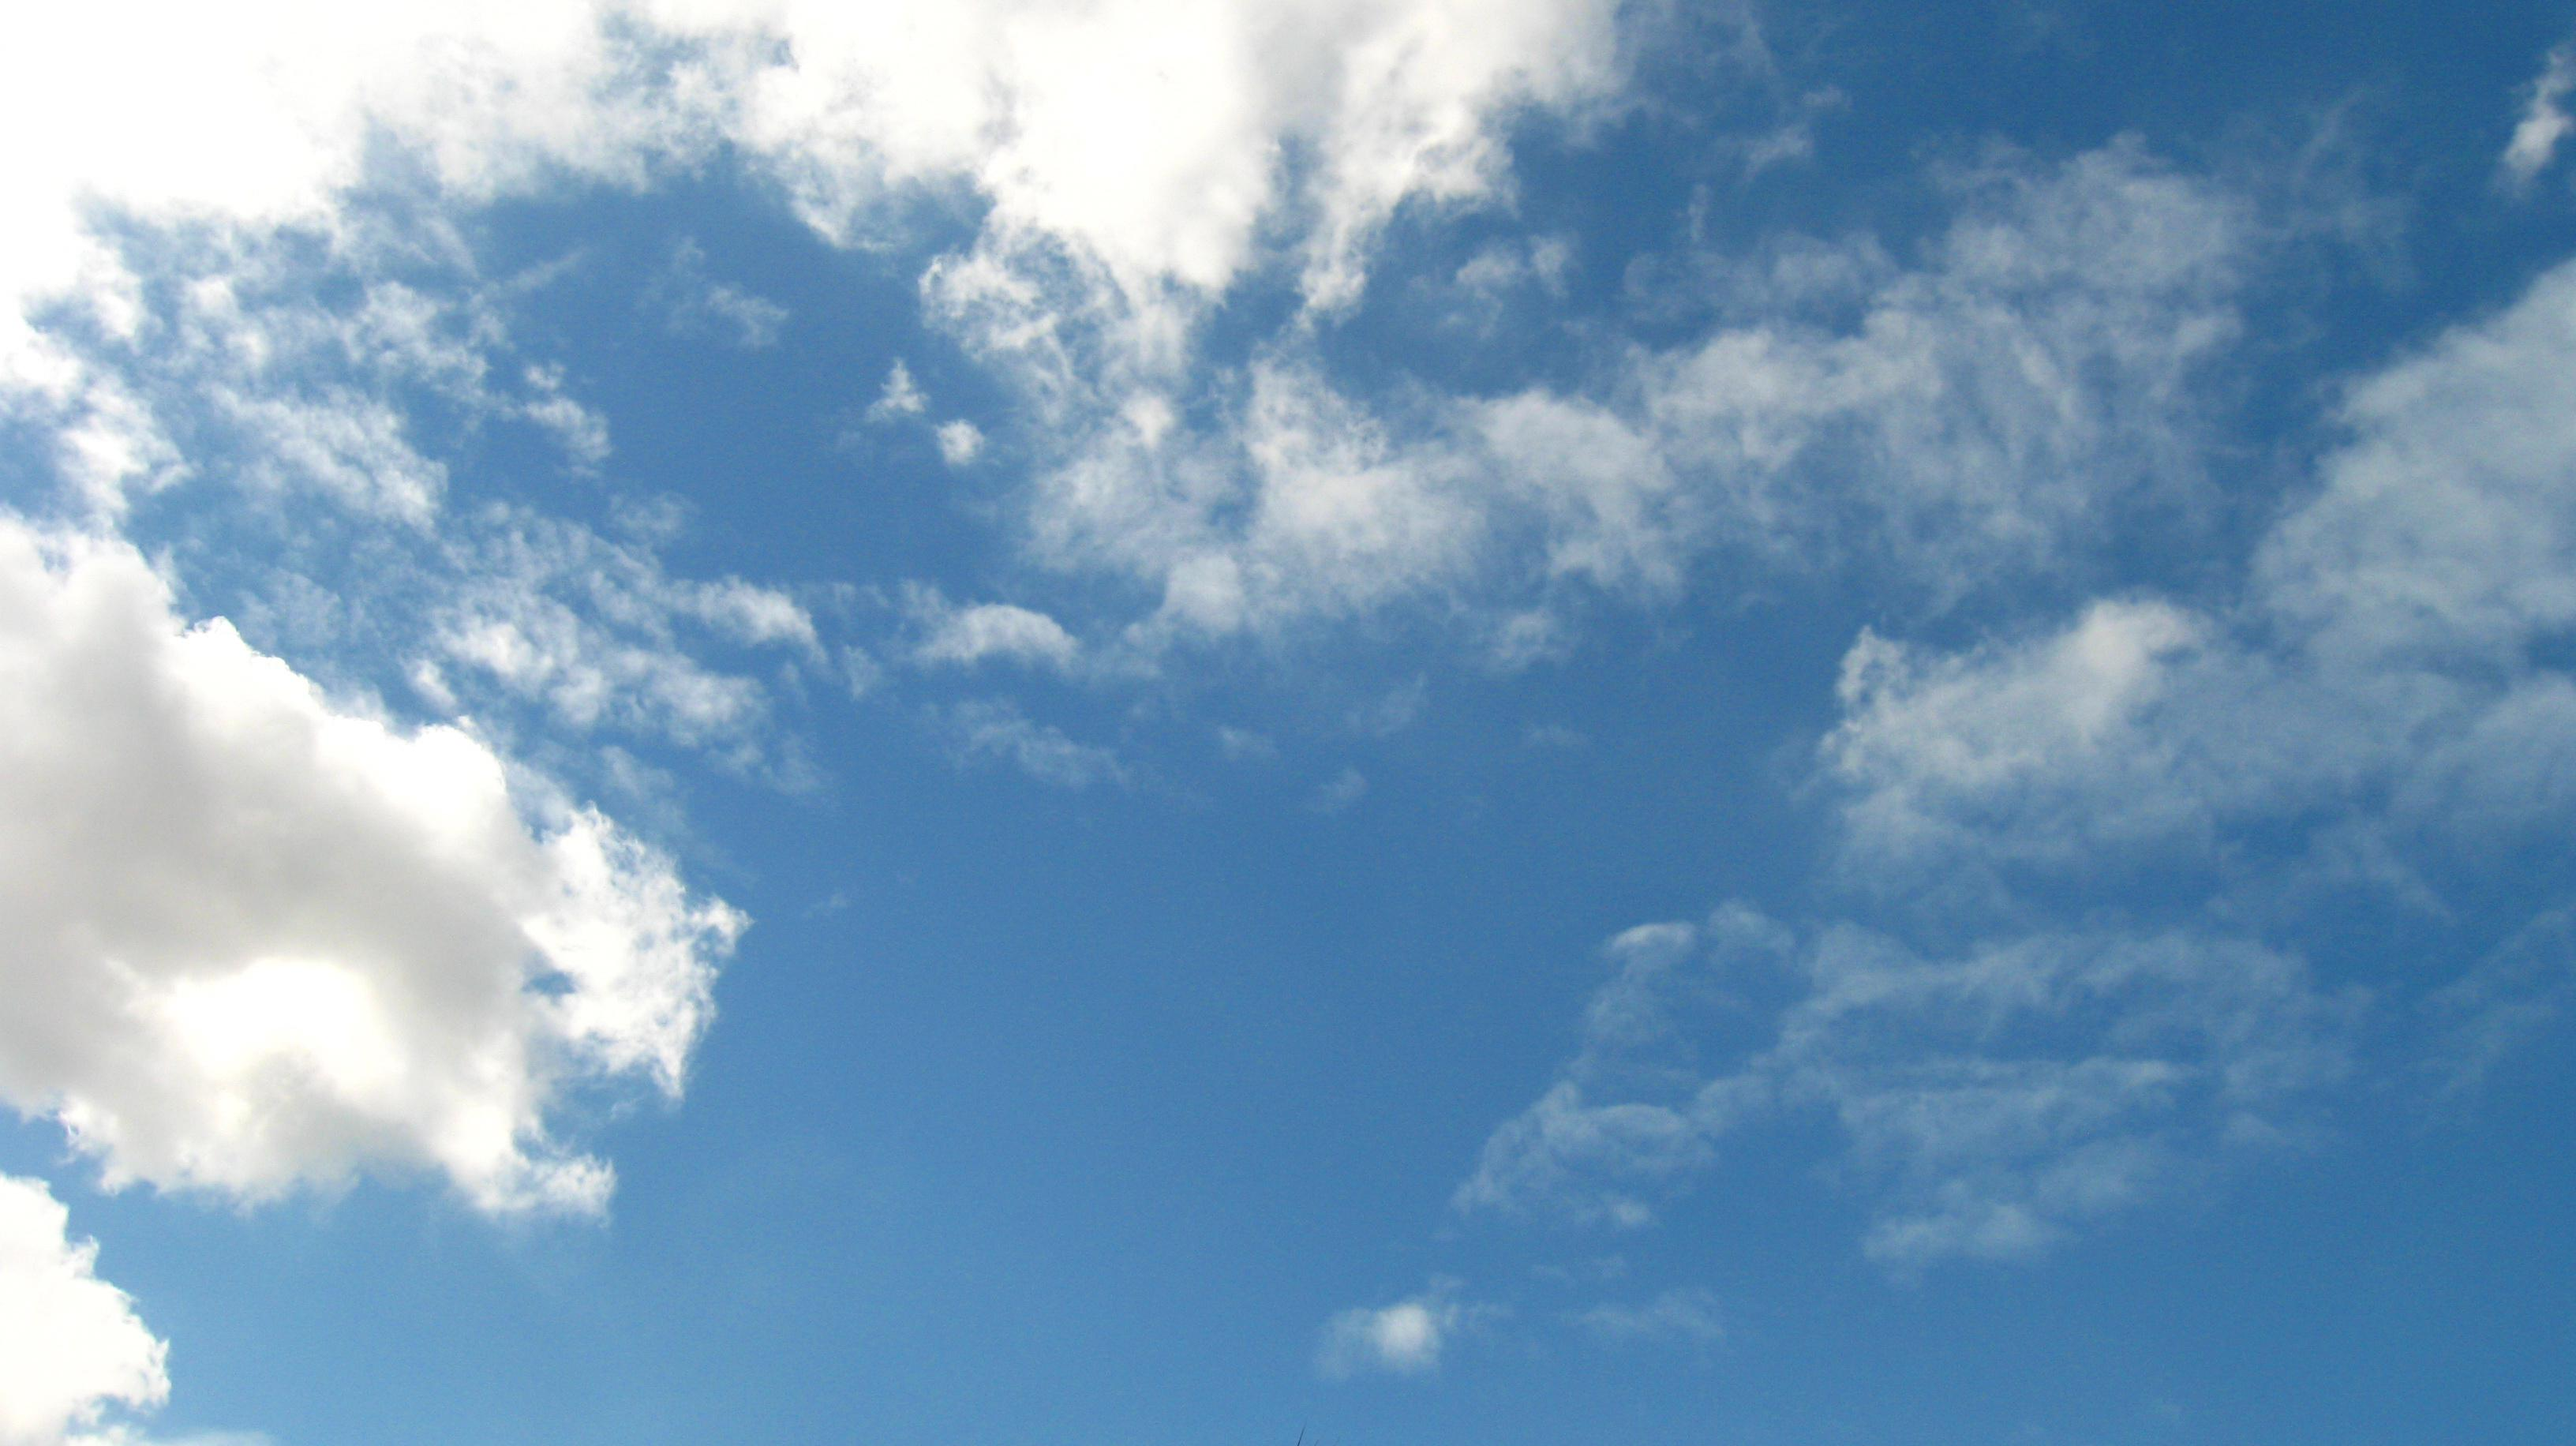

In [7]:
img = np.float32(PIL.Image.open('sky1024px.jpg'))
print(type(img))
print(img.shape)
showarray(img)


We have few pre-processes on the input image before feeding it into the net: minus mean image and scale done the input image.


(3, 1832, 3264)
<type 'numpy.ndarray'>
(3, 1, 1)
[[[ 104.]]

 [[ 116.]]

 [[ 122.]]]


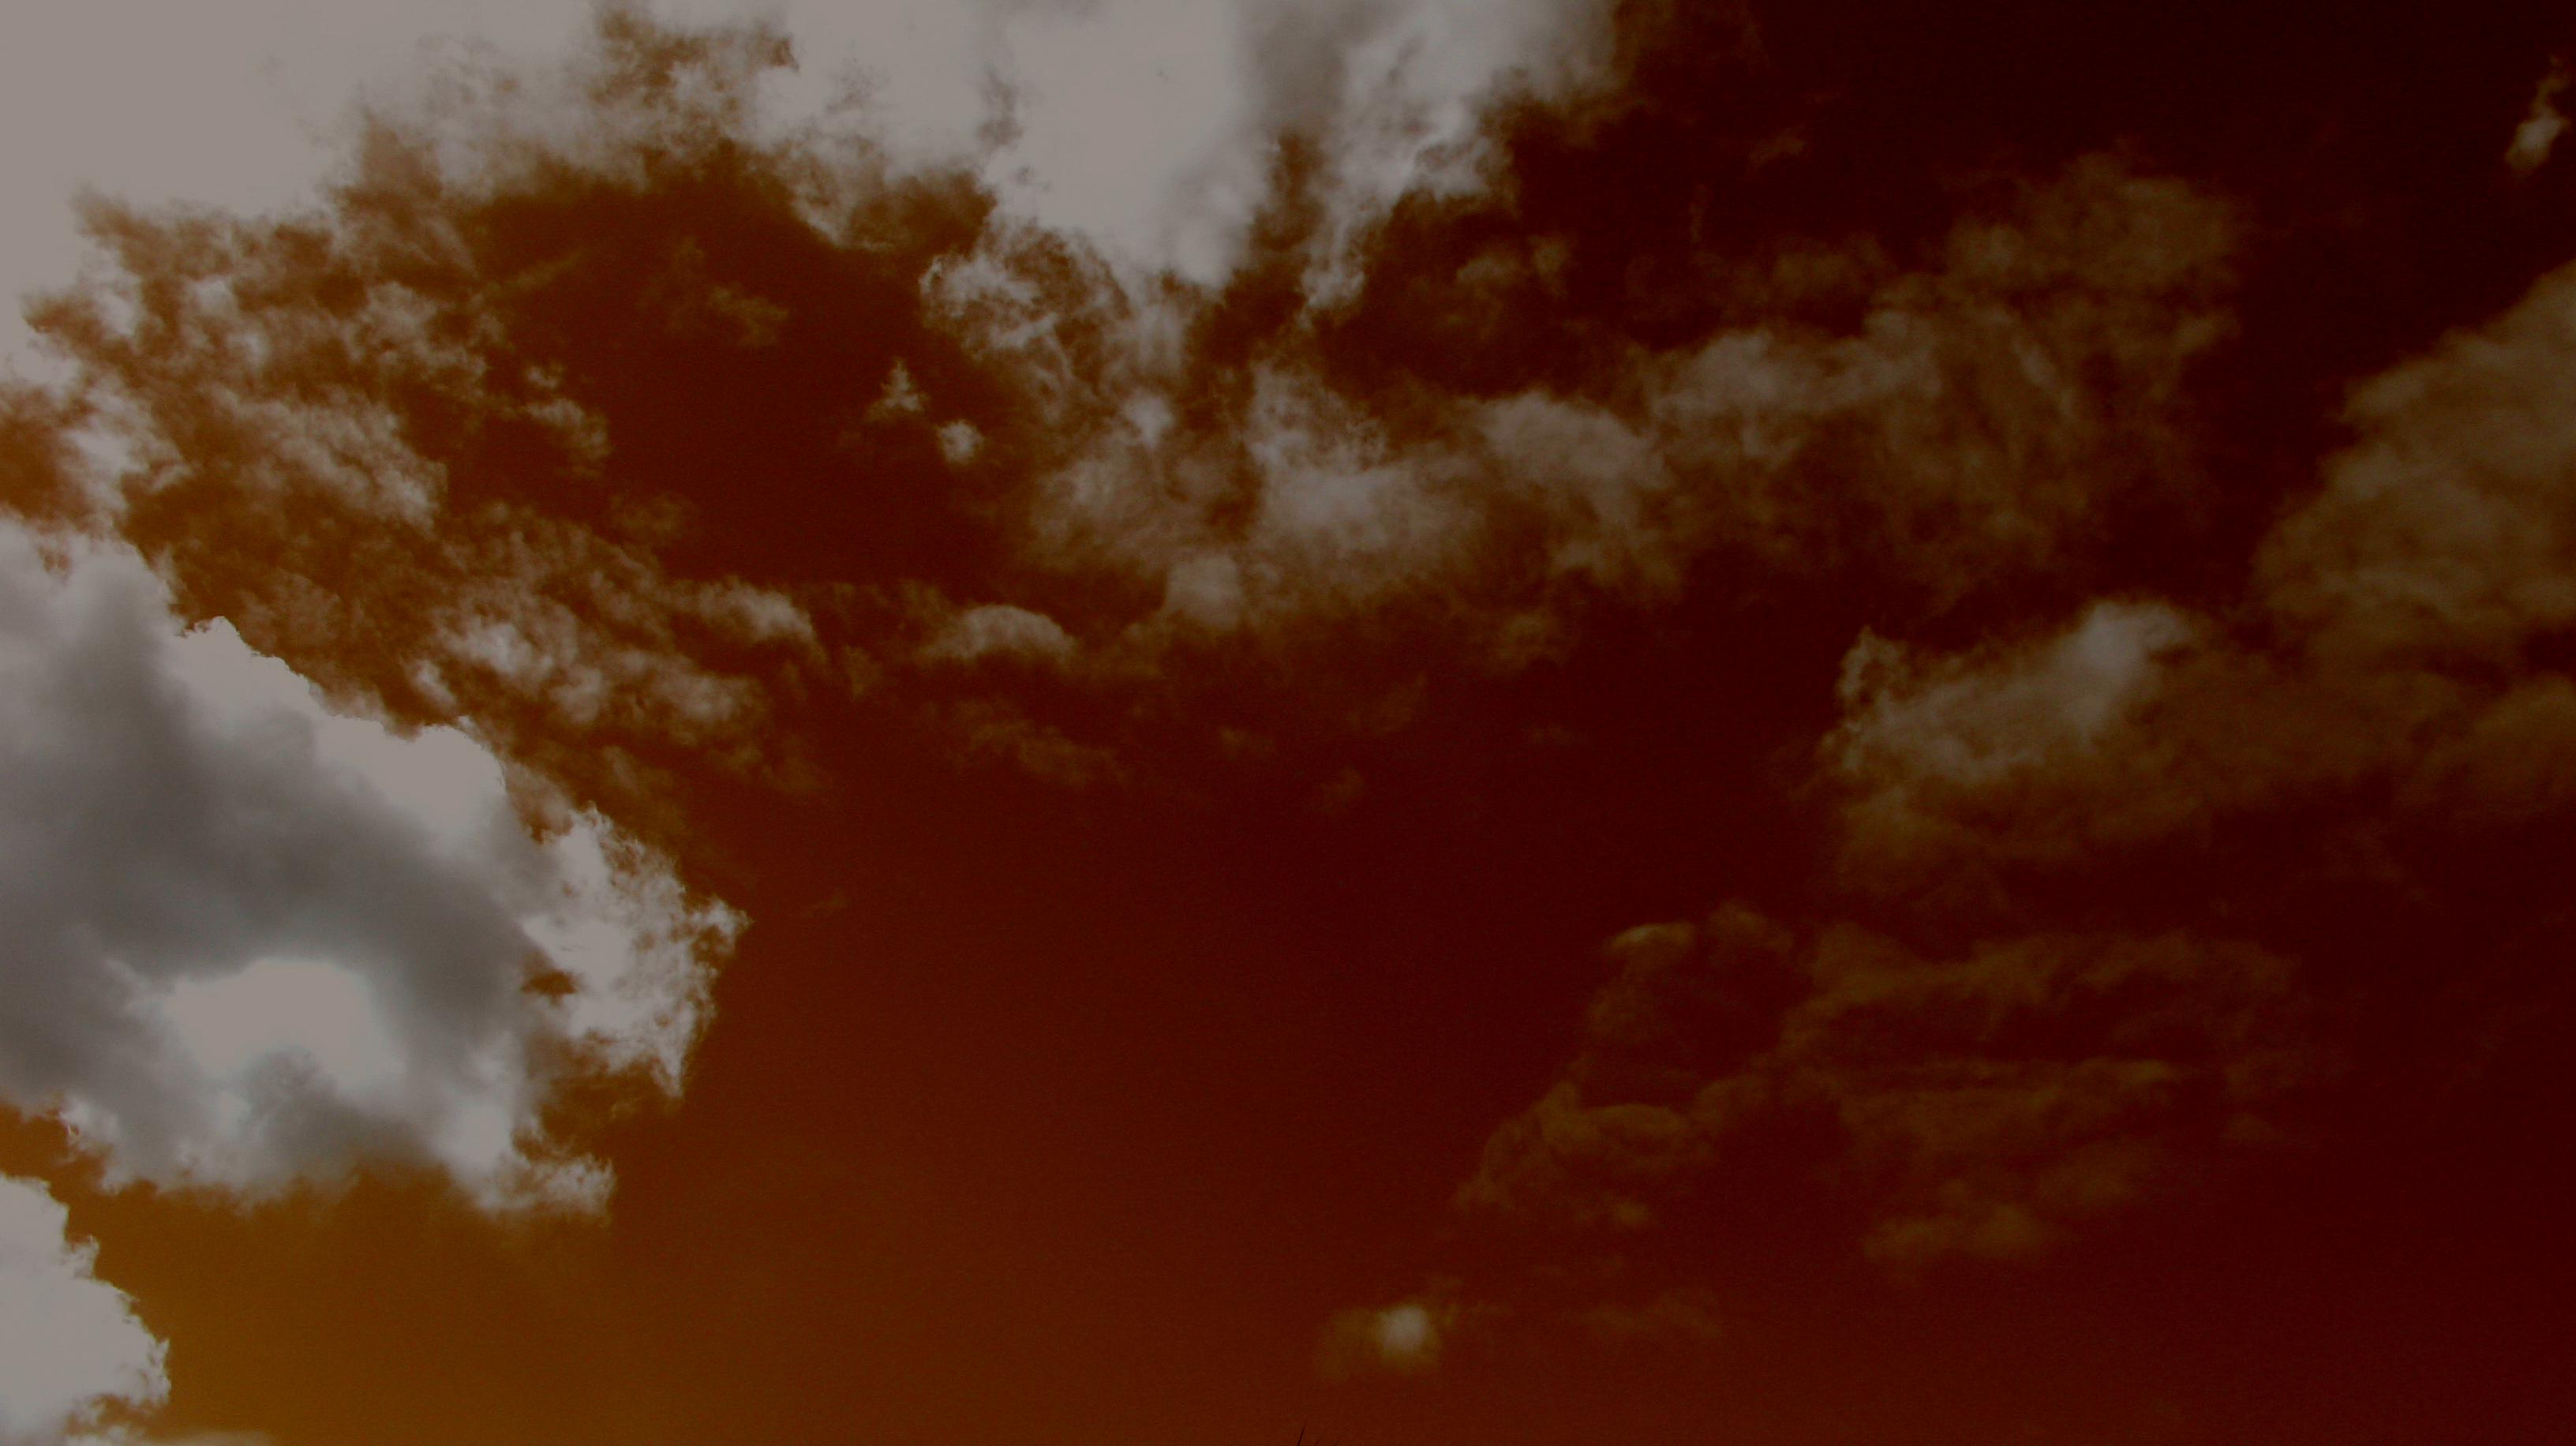

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(3, 1309, 2331)
(3, 935, 1665)
(3, 668, 1189)


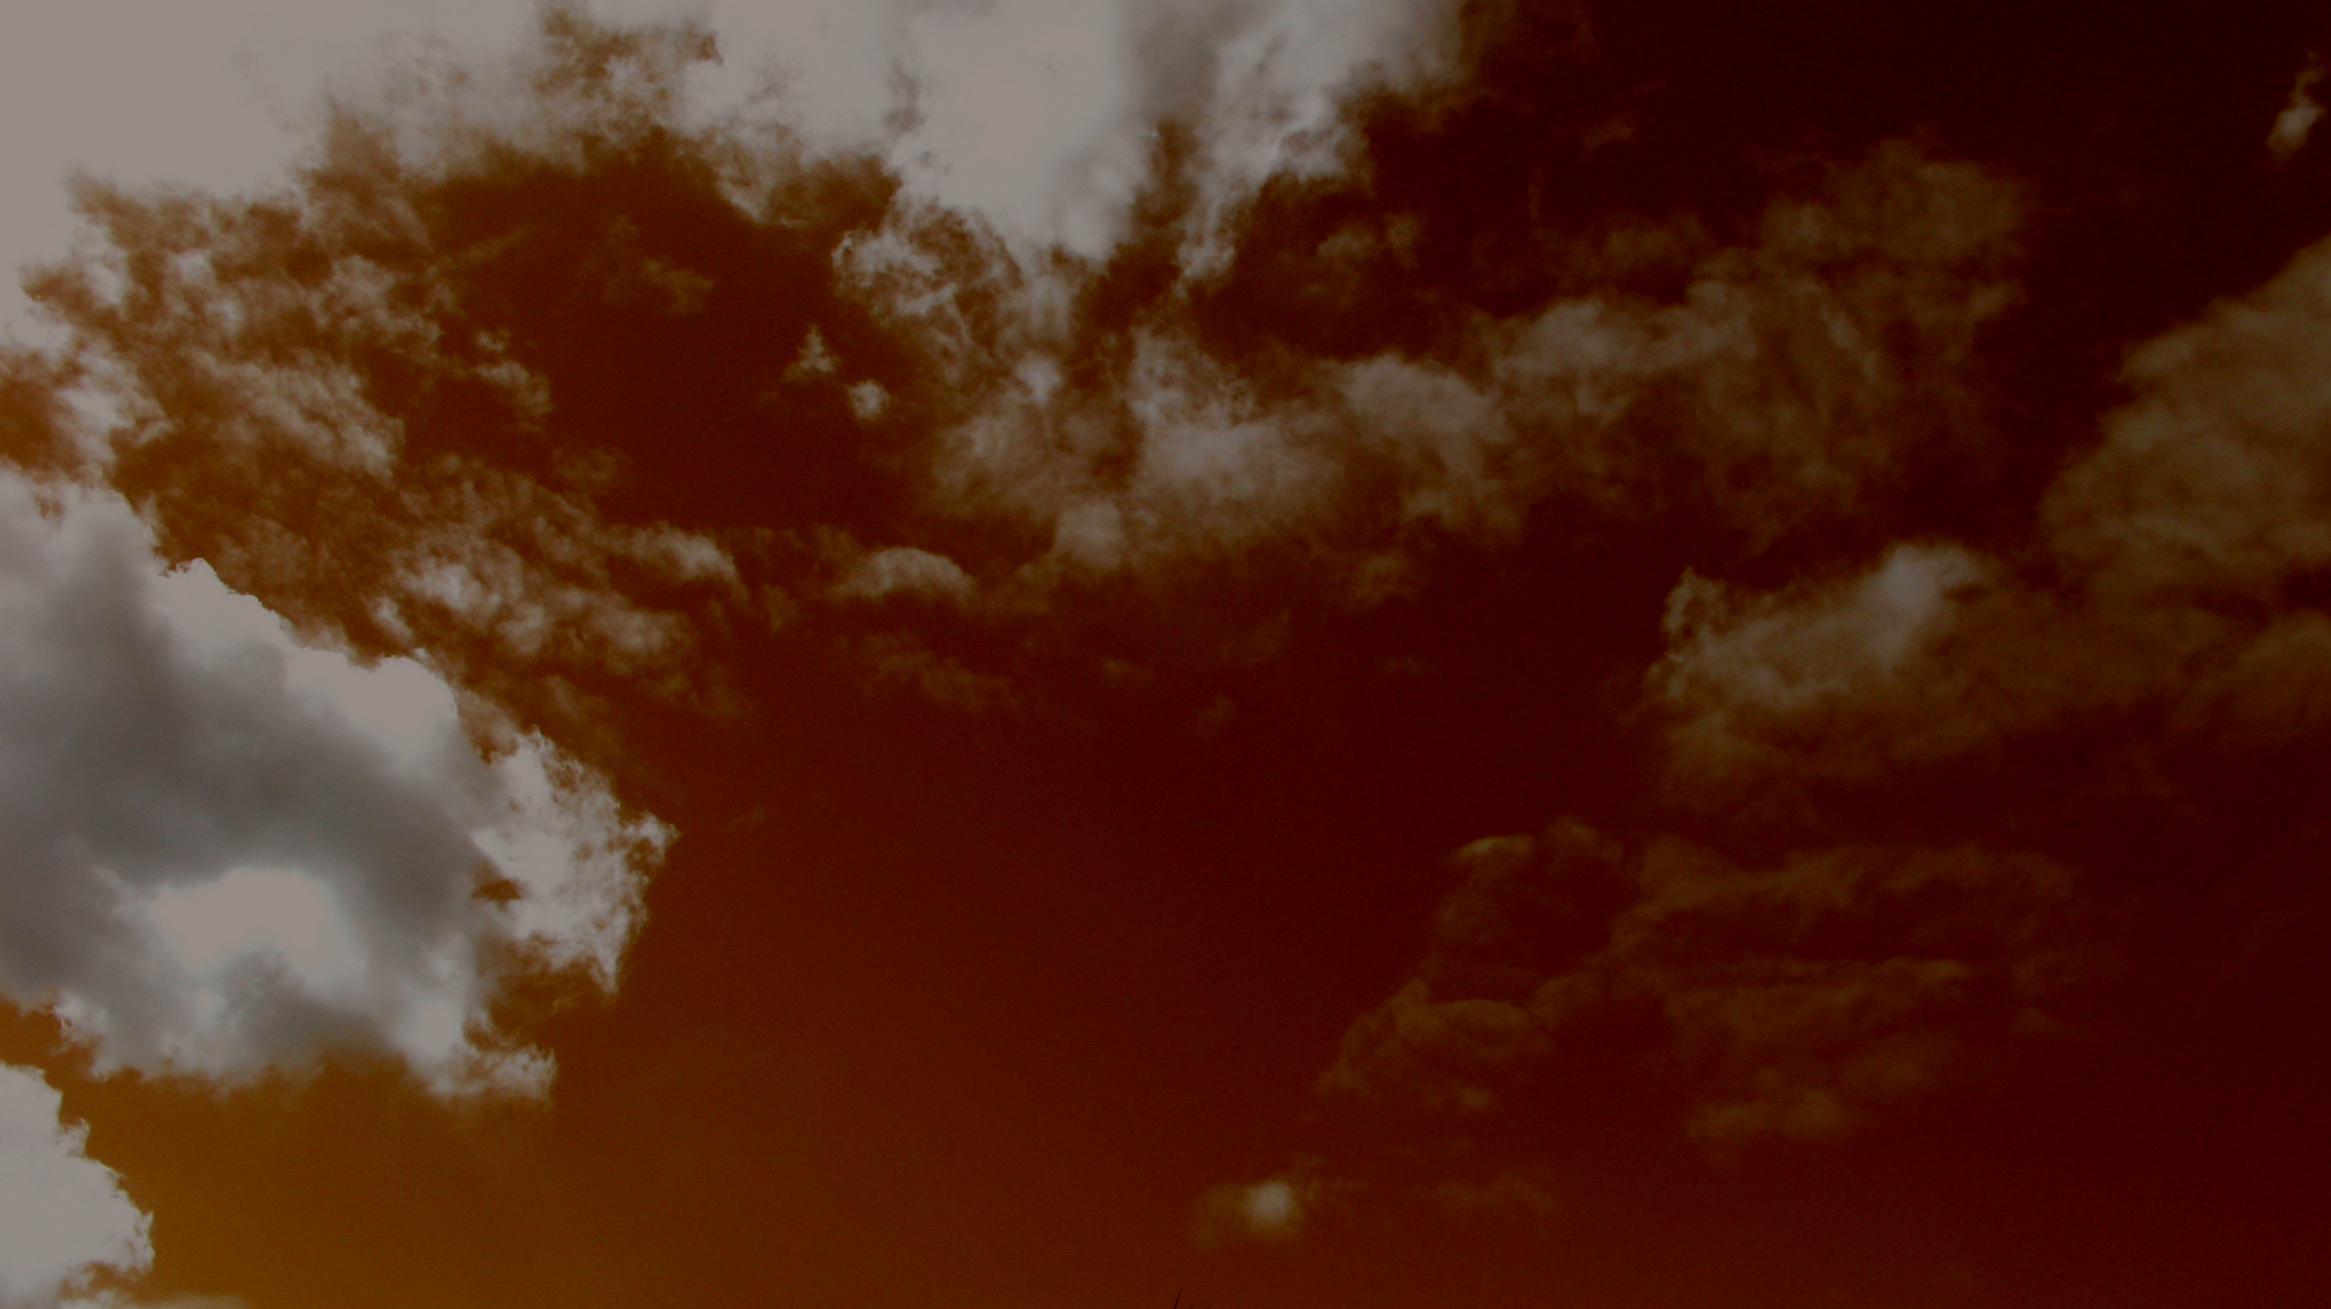

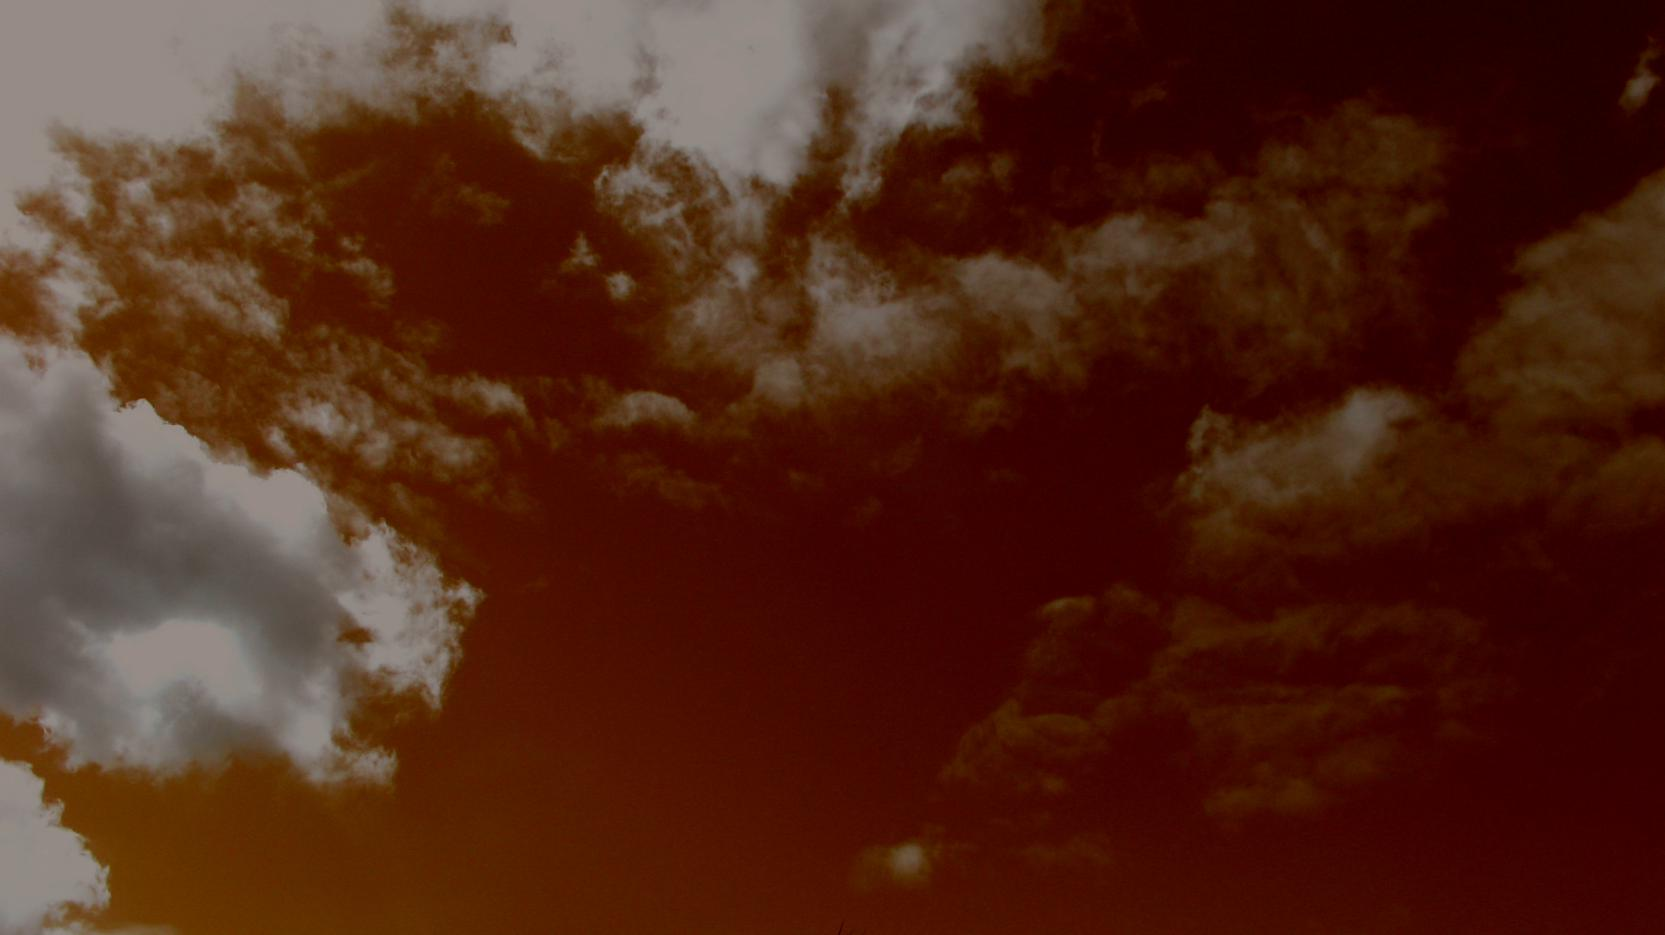

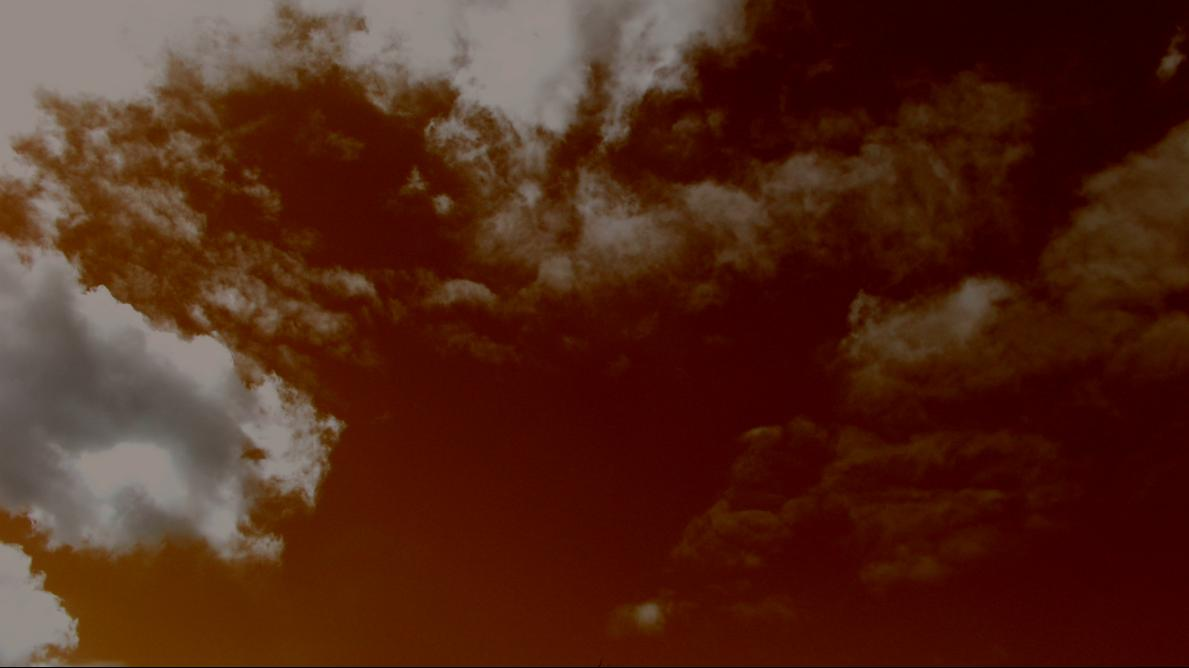

0
(3, 668, 1189)
1
(3, 935, 1665)
2
(3, 1309, 2331)
3
(3, 1832, 3264)
(3, 224, 224)
(10, 3, 224, 224)


In [8]:
# The preprocess of input image
octaves = [preprocess(net, img)]
print(octaves[0].shape)
print(type(octaves[0]))

# The mean of training set
print(net.transformer.mean['data'].shape)
print(net.transformer.mean['data'])

showarray(octaves[0].transpose(1, 2, 0))

# another pre-process on input image
# scale down the input image
octave_n=4
octave_scale=1.4
for i in xrange(octave_n-1):
    octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
print(octaves[1].shape)
print(octaves[2].shape)
print(octaves[3].shape)

showarray(octaves[1].transpose(1, 2, 0))
showarray(octaves[2].transpose(1, 2, 0))
showarray(octaves[3].transpose(1, 2, 0))

for octave, octave_base in enumerate(octaves[::-1]):
    print(octave)
    print(octave_base.shape)

src = net.blobs['data']
print(src.data[0].shape)
print(src.data[:].shape)

iter: 9
objective_L2 data: (1, 32, 229, 408) diff: (1, 32, 229, 408)


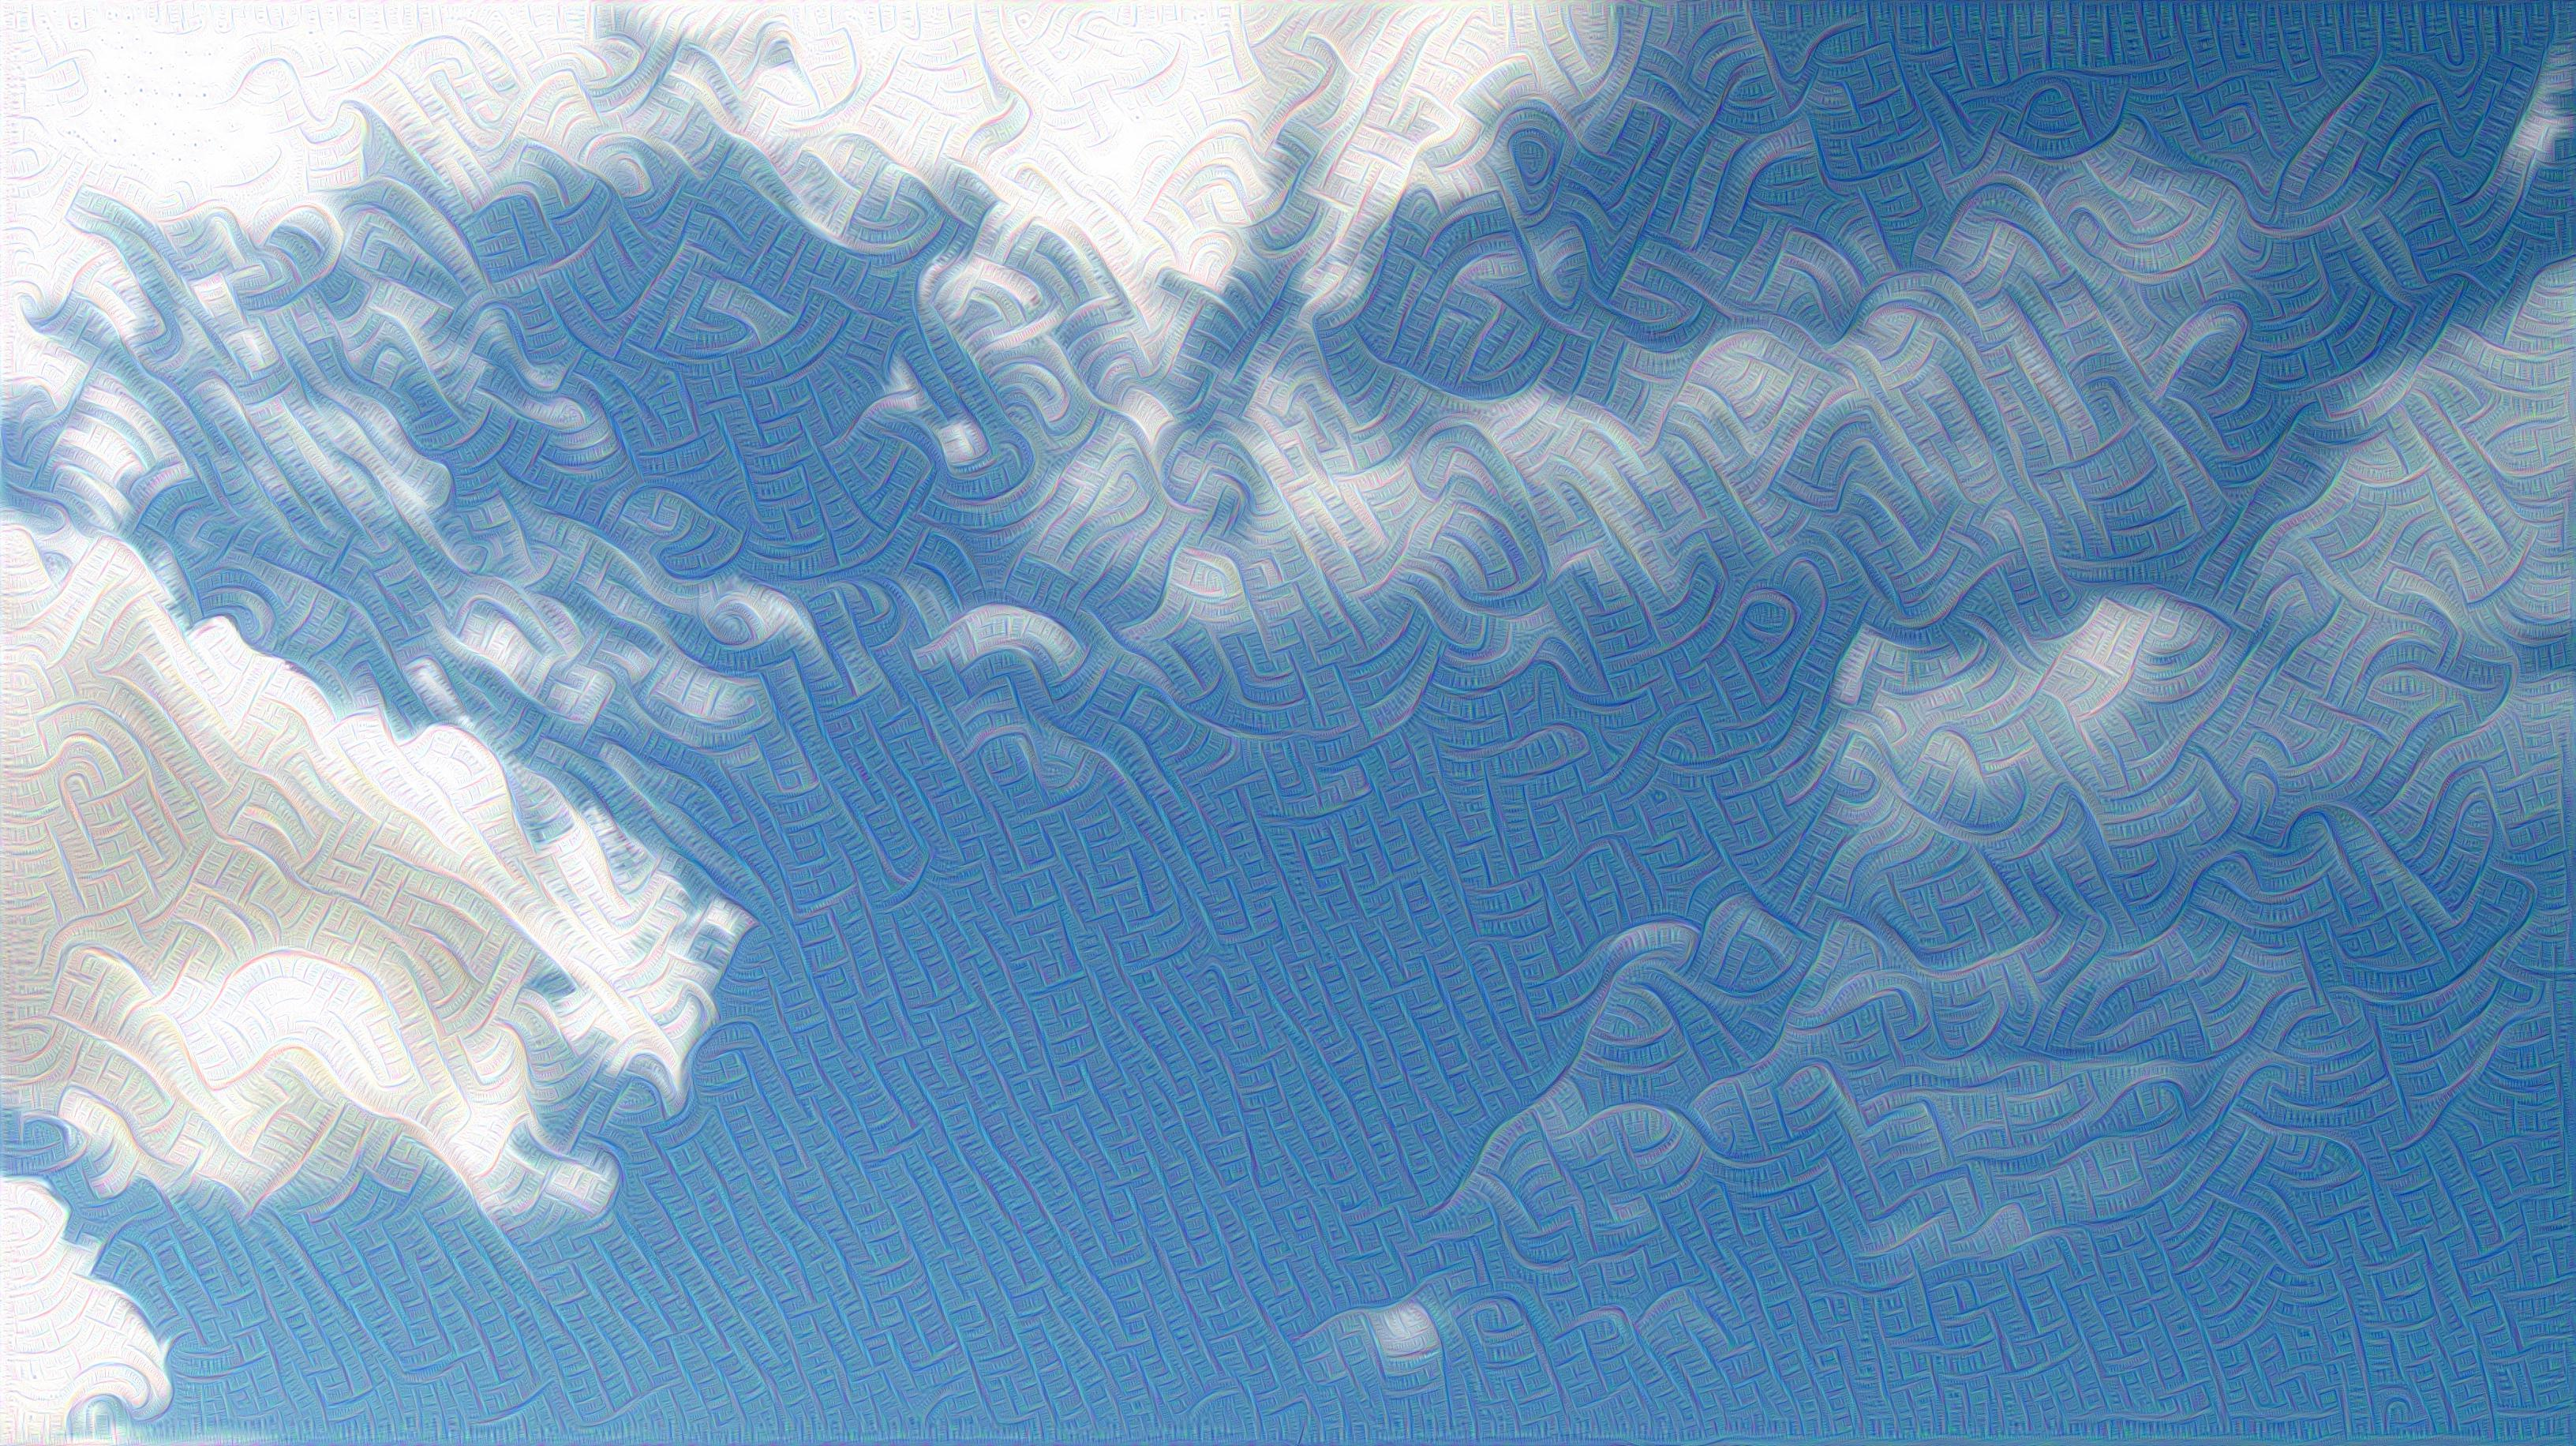

3 9 inception_3b/5x5_reduce (1832, 3264, 3)


In [9]:
_=deepdream(net, img, end="inception_3b/5x5_reduce")
